# Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import warnings

# Загружаем данные. Взял с финама историю https://www.finam.ru/quote/moex/sber/export/

In [2]:
os.chdir(r'd:\ml\временные ряды')
data= pd.read_csv('SBER_200101_240320.csv', delimiter=';')
data.tail()

,date,time,open,high,low,close,volume
1042,14/03/24,0,298.47,298.70,295.14,295.83,42076250
1043,15/03/24,0,295.75,299.44,295.29,298.68,22736700
1044,18/03/24,0,299.41,299.98,297.63,298.87,20213950
1045,19/03/24,0,298.30,299.40,294.21,295.20,59646690
1046,20/03/24,0,295.40,296.88,293.52,295.40,30646650


In [3]:
# отключаем предупреждения
warnings.filterwarnings("ignore")
# преобразуем дату в тип данных DateTime. 
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
# удалим колонку TIME - она нам не нужна. В принципе нам не нужны конолнки кроме даты и цены закрытия
data = data.drop('time', axis=1)
data = data.set_index('date')
# смотрим на пропуски в данных - пропусков нет
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1047 entries, 2020-01-03 to 2024-03-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1047 non-null   float64
 1   high    1047 non-null   float64
 2   low     1047 non-null   float64
 3   close   1047 non-null   float64
 4   volume  1047 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 49.1 KB


In [4]:
data.head()

,open,high,low,close,volume
date,,,,,
2020-01-03,255.97,258.19,253.70,255.00,35824160
2020-01-06,254.75,254.84,251.40,253.90,22327940
2020-01-08,253.62,259.15,253.03,259.15,40736030
2020-01-09,259.41,261.76,257.01,257.99,38196300
2020-01-10,257.91,259.25,256.88,258.19,18841650


# строим графики

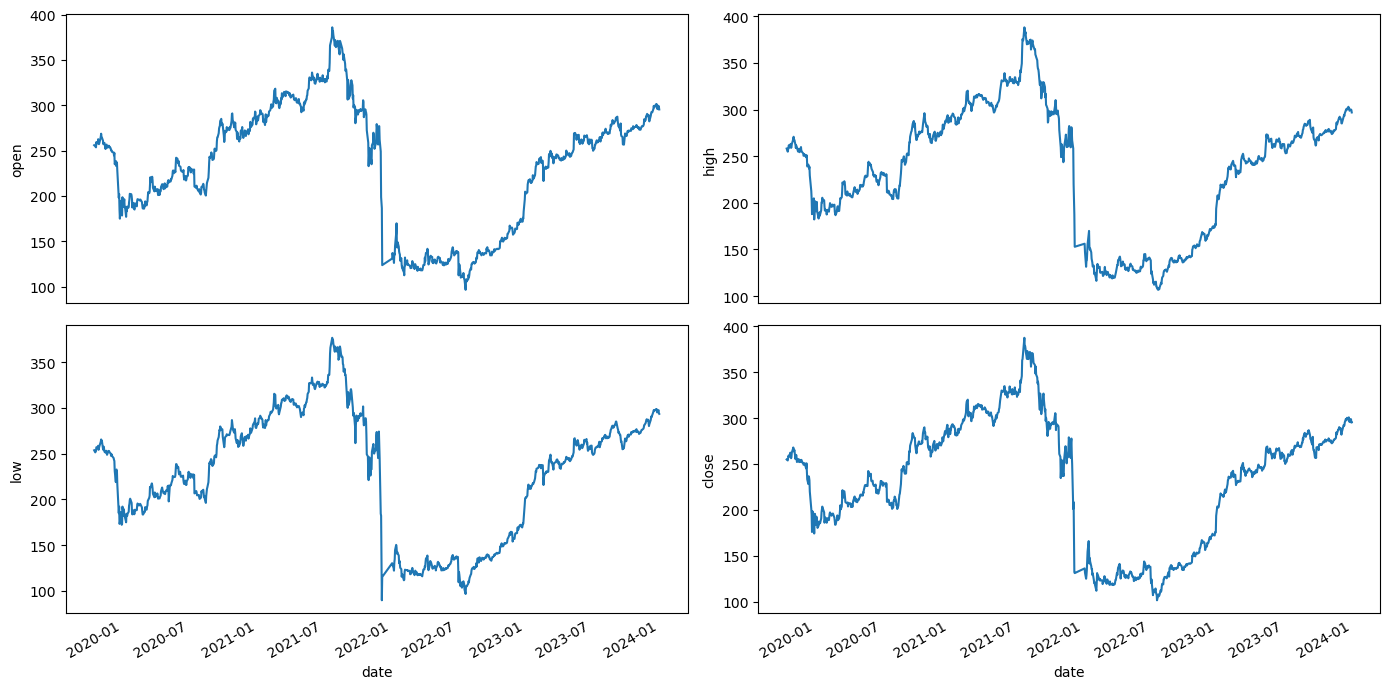

In [5]:
 def data_plot(df):
    df_plot = df.copy()
    #df_plot = df_plot.drop('date', axis=1) 
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))
 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

data_plot(data)

# Делим датасет на test и train. 80% на  train, 20% на  test

In [6]:
t_len = round(len(data)*0.8)

In [7]:
train_data = data[:t_len]
test_data = data[t_len:]
print(train_data.shape, test_data.shape)

(838, 5) (209, 5)


# Подготовка данных

In [8]:
dataset_train = train_data.close.values
# преобразуем данные в 2D-формат, подготавливаем обучающие данные для использования в нейронной сети
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(838, 1)

In [9]:
dataset_test = test_data.close.values
# преобразуем данные в 2D-формат, подготавливаем тестовые данные для использования в нейронной сети
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(209, 1)

# Нормализация

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)


In [11]:
# необходимо разделить данные временных рядов на X_train и y_train из обучающего набора и X_test и y_test из тестового набора. 
# данные временных рядов преобразуются в задачу обучения с контролем, которая может быть использована для разработки модели. 
# При итерации данных временных рядов цикл генерирует последовательности ввода/вывода длиной 30 для обучающих данных  и для тестовых данных. 
sequence_length = 30  # для создания X_train
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# преобразуем данные в  PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([808, 30, 1]), torch.Size([808, 30, 1]))

In [12]:
X_train[0]

tensor([[0.5365],
        [0.5327],
        [0.5510],
        [0.5470],
        [0.5477],
        [0.5624],
        [0.5507],
        [0.5411],
        [0.5453],
        [0.5627],
        [0.5760],
        [0.5822],
        [0.5769],
        [0.5670],
        [0.5732],
        [0.5376],
        [0.5460],
        [0.5538],
        [0.5446],
        [0.5267],
        [0.5330],
        [0.5379],
        [0.5372],
        [0.5264],
        [0.5341],
        [0.5269],
        [0.5348],
        [0.5348],
        [0.5326],
        [0.5252]])

In [13]:
y_train[0]

tensor([[0.5327],
        [0.5510],
        [0.5470],
        [0.5477],
        [0.5624],
        [0.5507],
        [0.5411],
        [0.5453],
        [0.5627],
        [0.5760],
        [0.5822],
        [0.5769],
        [0.5670],
        [0.5732],
        [0.5376],
        [0.5460],
        [0.5538],
        [0.5446],
        [0.5267],
        [0.5330],
        [0.5379],
        [0.5372],
        [0.5264],
        [0.5341],
        [0.5269],
        [0.5348],
        [0.5348],
        [0.5326],
        [0.5252],
        [0.5238]])

In [14]:
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# преобразуем данные в PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([179, 30, 1]), torch.Size([179, 30, 1]))

# Создаем LSTM класс

In [15]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [16]:
# проверяем железо
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Описываем модель

In [17]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
# model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


# загрузка данных

In [18]:
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# тренировка

In [19]:
num_epochs = 50
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
    total_loss = 0.0
 
    # тренировка
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # проверка
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0012, Test Loss: 0.0029
Epoch [20/50] - Training Loss: 0.0005, Test Loss: 0.0024
Epoch [30/50] - Training Loss: 0.0004, Test Loss: 0.0023
Epoch [40/50] - Training Loss: 0.0004, Test Loss: 0.0023
Epoch [50/50] - Training Loss: 0.0004, Test Loss: 0.0024


# построили график обучения

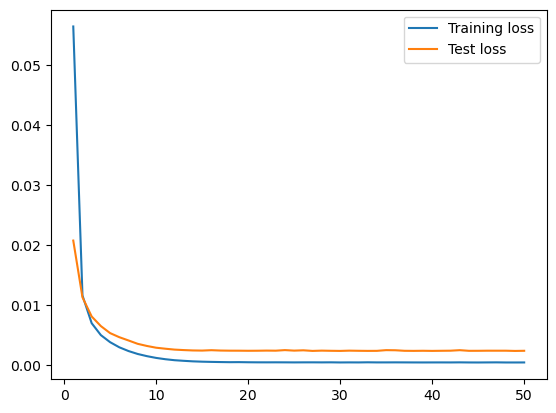

In [20]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

# Предсказание

In [21]:
# Кол-во шагов для предсказания
num_forecast_steps = 30
 
# конвертируем в  NumPy
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
# будем строить график для  30 последних значений + 30 предсказывать
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # предсказывем цену
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        #создаем лист с предсказанной ценой
        forecasted_values.append(predicted_value[0])
 
        # обновляем исторические данные со сдвигом
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
         
# создаем ряд будущих дат
last_date = test_data.index[-1]
 
#создаем следующие 30 дат
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# объединяем
combined_index = test_data.index.append(future_dates)

(30,)


In [22]:
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Строим график

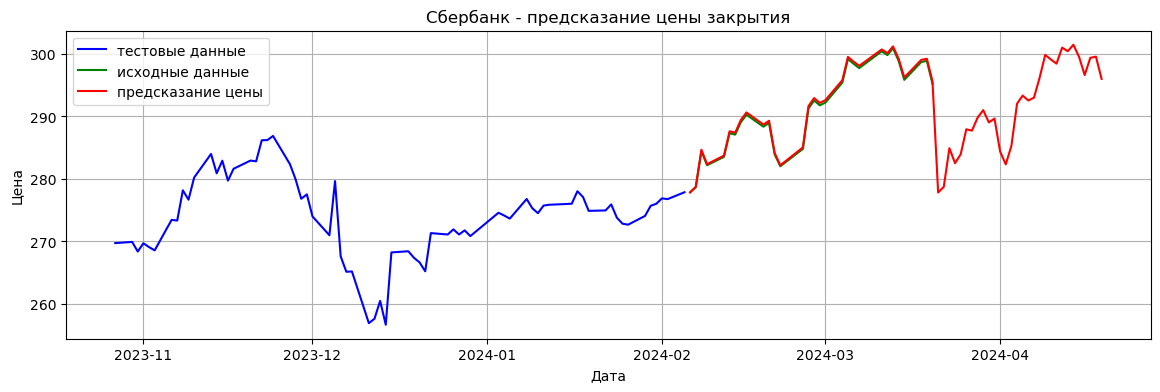

In [23]:
plt.rcParams['figure.figsize'] = [14, 4] 
 
# тестовые данные
plt.plot(test_data.index[-100:-30], test_data.close[-100:-30], label = "тестовые данные", color = "b") 
#обратное преобразование
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
# исходные данные
plt.plot(test_data.index[-30:], original_cases, label='исходные данные', color='green') 
 
#предсказание
#обратное преобразование
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='предсказание цены', color='red', )  

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.title('Сбербанк - предсказание цены закрытия')
plt.grid(True)
plt.show()